# StyleCLIP+: Design Flexibility Improvement
Fall 2023 CS470 Introduction to Artificial Intelligence Project 2 (Implementation), Team 3  
Myeongseok Kwon<sup>1</sup>, Junhak Ha<sup>2</sup>, Dongwan Hong<sup>3</sup>, Kyeongmin Lee<sup>4</sup>, Bryan Nathanael Wijaya<sup>5*</sup>  
<small><sup>1</sup>20170042, <sup>2</sup>20190683, <sup>3</sup>20190696, <sup>4</sup>20200429, <sup>5</sup>20200735, <sup>*</sup>Team Leader</small>

**Remarks:** This notebook is extended from the implementation by Dongbin Na.

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-y7lstupq
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-y7lstupq
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=1ba736e8496d53c6befe544c0d41e807261d4520d681cbc14cd0aec00feb0ed5
  Stored in directory: /tmp/pip-ephem-wheel-cache-3p2l2lpx/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


#### <b>Load the Pre-trained StyleGAN Model</b>

* StyleGAN is an efficient architecture to generate high-quality images.

In [ ]:
!git clone https://github.com/ndb796/StyleCLIP-Tutorial
%cd StyleCLIP-Tutorial

Cloning into 'StyleCLIP-Tutorial'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 64 (delta 19), reused 10 (delta 0), pack-reused 0
Receiving objects: 100% (64/64), 3.33 MiB | 4.46 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/StyleCLIP-Tutorial


In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1 -O stylegan2-ffhq-config-f.pt

--2023-12-07 10:30:18--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt?ga=1 [following]
--2023-12-07 10:30:19--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 381462551 (364M) [application/octet-stream]
Saving to: ‘stylegan2-ffhq-config-f.pt’

stylegan2-ffhq-conf 100%[===================>] 363.79M  90.8MB/s    in 6.0s    


In [ ]:
import torch
from stylegan2.model import Generator


g_ema = Generator(1024, 512, 8)
g_ema.load_state_dict(torch.load('stylegan2-ffhq-config-f.pt')["g_ema"], strict=False)
g_ema.eval()
g_ema = g_ema.cuda()

#### <b>CLIP Loss</b>

In [ ]:
import clip


class CLIPLoss(torch.nn.Module):

    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)

    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image))
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity

#### <b>Latent Optimization</b>

* The basic idea is as follows:

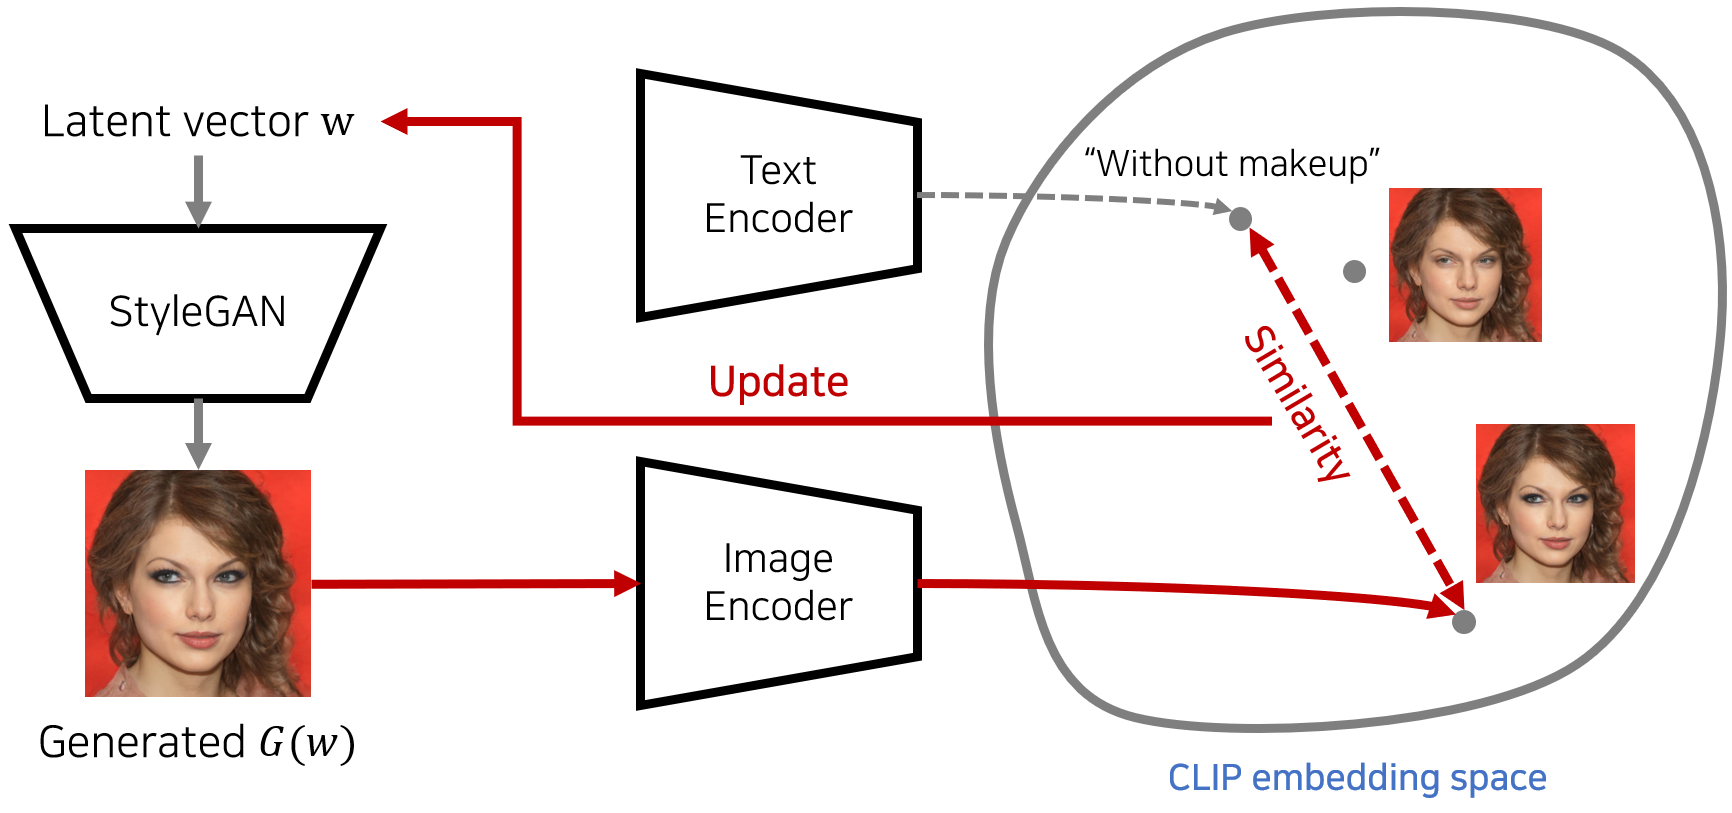

# Here is the Improvement Part!

* The user can initialize the number of images they want to consider as a candidate!

* So they can use more than one image!

In [ ]:
number_of_images_you_want = 7 #@param {type:"number"}

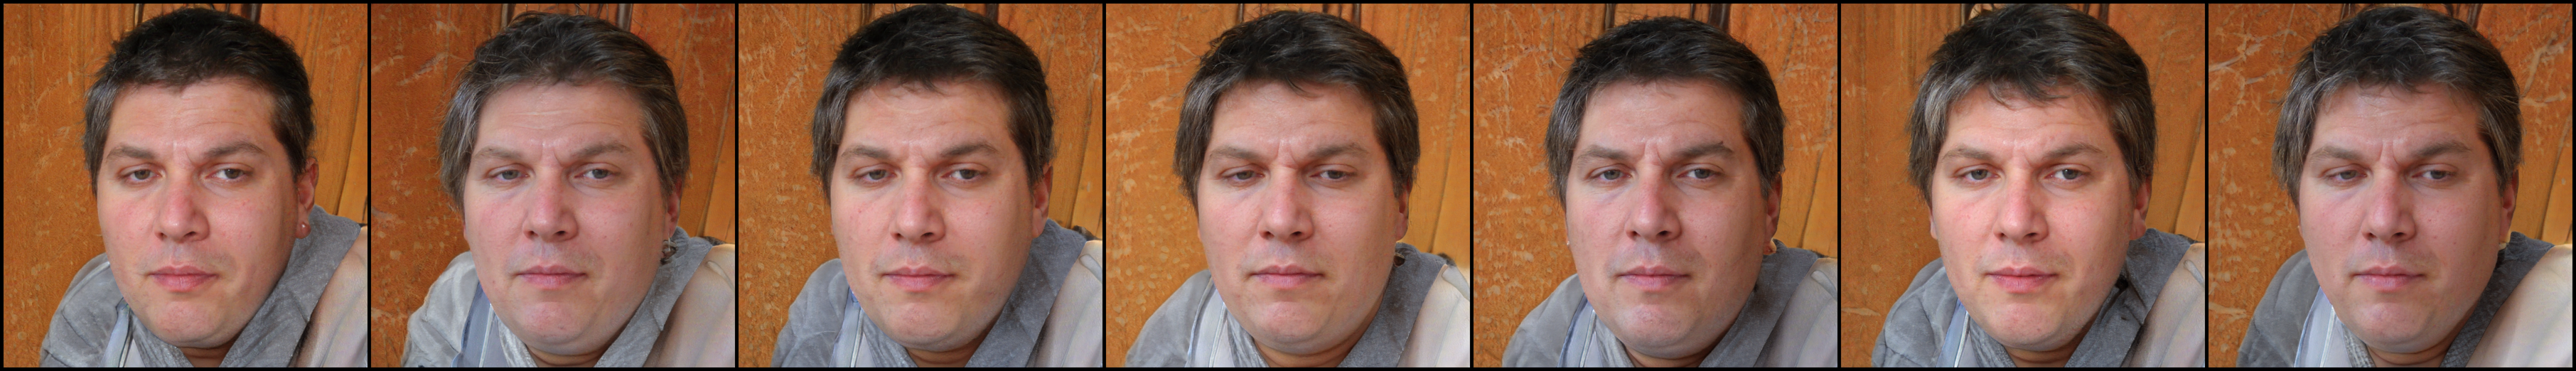

In [ ]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage


mean_latent = g_ema.mean_latent(4096)

latent_code_init_not_trunc = torch.randn(1, 512).cuda()

""" with torch.no_grad():
    img_orig, latent_code_init = g_ema([latent_code_init_not_trunc], return_latents=True,
                                truncation=0.7, truncation_latent=mean_latent)

# Visualize a random latent vector.
# image = ToPILImage()(make_grid(img_orig.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
image = ToPILImage()(make_grid(img_orig.detach().cpu(), normalize=True, scale_each=True, padding=0))
h, w = image.size
image.resize((h // 2, w // 2)) """

# Generate diverse yet similar latent vectors
num_vectors = number_of_images_you_want
variations = [torch.randn_like(latent_code_init_not_trunc) * 0.1 for _ in range(num_vectors)]
latent_codes = [latent_code_init_not_trunc + variation for variation in variations]

# Generate and collect images from each latent vector
images = []
latent_vectors_collect = []

for latent_code in latent_codes:
    with torch.no_grad():
        img, latent_code_n = g_ema([latent_code], return_latents=True, truncation=0.7, truncation_latent=mean_latent)
        images.append(img)
        latent_vectors_collect.append(latent_code_n)

# Concatenate all images into a tensor
all_images = torch.cat(images, dim=0)

# Convert to PIL image for visualization
grid_image = ToPILImage()(make_grid(all_images.detach().cpu(), normalize=True, scale_each=True, padding=10))
h, w = grid_image.size
resized_image = grid_image.resize((h // 2, w // 2))

# Display the image
display(resized_image)

* Set parameters by yourself as you want to.

In [ ]:
from argparse import Namespace

description = 'A person with pink hair' #@param {type:"string"}
learning_rate = 0.1 #@param {type:"number"}
optimization_steps = 150 #@param {type:"number"}
l2_lambda = 0.005 #@param {type:"number"}

args = Namespace()
args.description = description # Change here for your text
args.lr_rampup = 0.05
args.lr = learning_rate
args.step = optimization_steps # 반복 횟수
args.l2_lambda = l2_lambda # The weight for similarity to the original image.
args.save_intermediate_image_every = 1
args.results_dir = 'results'

* Optimize the latent vectors and get the visualtization of the result

Num 1 Latent Vector Image


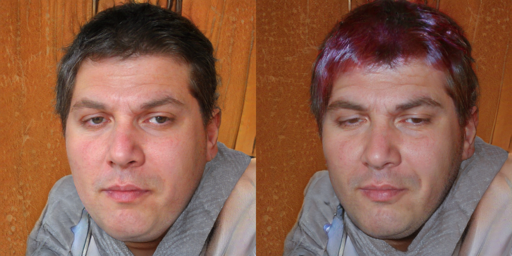

Num 2 Latent Vector Image


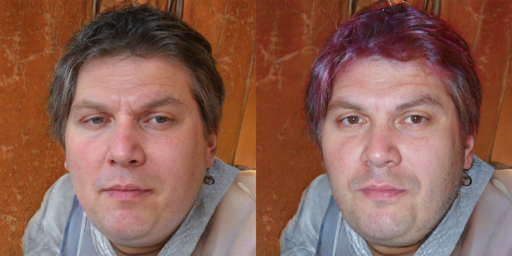

Num 3 Latent Vector Image


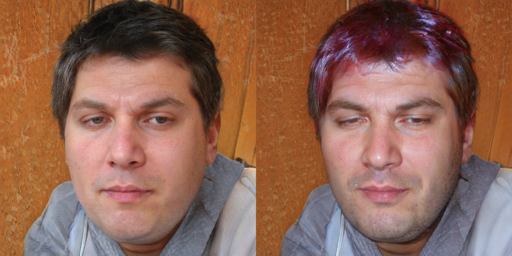

Num 4 Latent Vector Image


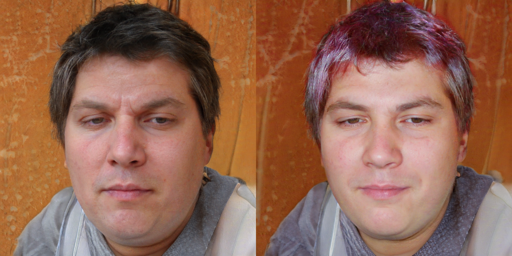

Num 5 Latent Vector Image


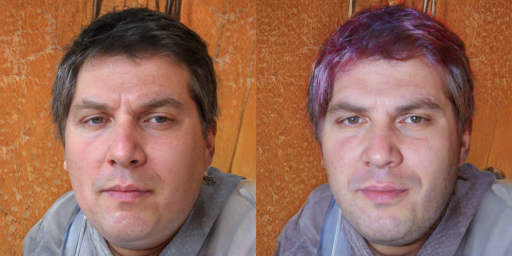

Num 6 Latent Vector Image


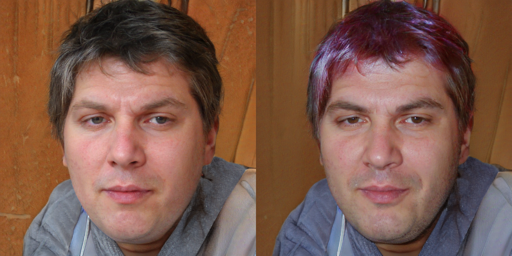

Num 7 Latent Vector Image


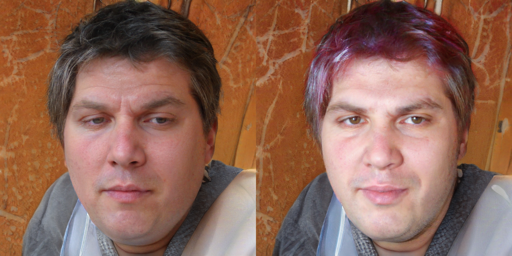

In [ ]:
import os
import math
import torchvision
from torch import optim


# The learning rate adjustment function.
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp


text_inputs = torch.cat([clip.tokenize(args.description)]).cuda()
os.makedirs(args.results_dir, exist_ok=True)

j = 1

for latent_code_n in latent_vectors_collect:
    print("Num", j,"Latent Vector Image")
    latent_code_init = latent_code_n.cuda()
    # Initialize the latent vector to be updated.
    latent = latent_code_init.detach().clone()
    latent.requires_grad = True

    clip_loss = CLIPLoss()
    optimizer = optim.Adam([latent], lr=args.lr)

    for i in range(args.step):
        # Adjust the learning rate.
        t = i / args.step
        lr = get_lr(t, args.lr)
        optimizer.param_groups[0]["lr"] = lr

        # Generate an image using the latent vector.
        img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)

        # Calculate the loss value.
        c_loss = clip_loss(img_gen, text_inputs)
        l2_loss = ((latent_code_init - latent) ** 2).sum()
        loss = c_loss + args.l2_lambda * l2_loss

        # Get gradient and update the latent vector.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log the current state.
        if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
            with torch.no_grad():
                img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)
            # torchvision.utils.save_image(img_gen, f"results/{str(i).zfill(5)}.png", normalize=True, range=(-1, 1))
            torchvision.utils.save_image(img_gen, f"results/{str(i).zfill(5)}.png", normalize=True)

    with torch.no_grad():
        img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

    # Display the initial image and result image.
    final_result = torch.cat([img_orig, img_gen])
    # torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir, "final_result.jpg"), normalize=True, scale_each=True, range=(-1, 1))
    torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir, "final_result.jpg"), normalize=True, scale_each=True)

    result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, padding=0))
    h, w = result_image.size
    smaller = result_image.resize((h // 4, w // 4))

    display(smaller)

    j = j + 1